# Robust Methods to Generate Synthetic Table Data

## Робастные методы генерации синтетических табличных данных

**Автор оригинальной статьи:** W. Brett Kennedy  
**Источник:** [AI Advances / Medium](https://medium.com/ai-advances/robust-methods-to-generate-synthetic-table-data-91962bcf8466)  
**Книга автора:** [Outlier Detection in Python](https://www.manning.com/books/outlier-detection-in-python)

---

### Цель ноутбука

Этот ноутбук демонстрирует методы генерации **синтетических табличных данных**, которые сохраняют распределения и взаимосвязи между признаками, присутствующие в реальных данных.

### Зачем нужны синтетические данные?

- **Анонимизация:** создание статистически похожих данных без идентифицируемых реальных сущностей
- **Тестирование:** генерация тестовых данных для программных систем
- **Аугментация:** расширение обучающих выборок для ML-моделей
- **Детекция выбросов:** создание типичных и аномальных данных для тестирования детекторов

### Методы, рассматриваемые в ноутбуке

1. **Наивный метод** — независимая генерация каждого столбца по его распределению
2. **Предиктивная модель (Left-to-Right)** — последовательная генерация с учётом уже сгенерированных значений
3. **Gaussian Mixture Model (GMM)** — генерация на основе модели плотности распределения

---
## 1. Импорт библиотек и загрузка данных

In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Машинное обучение
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.mixture import GaussianMixture

# Настройки отображения
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Для воспроизводимости
np.random.seed(42)

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


### 1.1 Загрузка датасета Baseball

Будем использовать датасет **Baseball** из OpenML — он содержит статистику бейсболистов:
- Количество сезонов
- Количество ударов (At bats)
- Даблы, триплы, хоум-раны
- RBI (Runs Batted In) и др.

In [2]:
# Загрузка данных с OpenML
data = fetch_openml('baseball', version=1, parser='auto')
df = pd.DataFrame(data.data, columns=data.feature_names)

# Заполнение пропусков медианой
df['Strikeouts'] = df['Strikeouts'].fillna(df['Strikeouts'].median())

print(f"Размер датасета: {df.shape}")
print(f"\nПризнаки: {list(df.columns)}")
df.head(10)

Размер датасета: (1340, 16)

Признаки: ['Number_seasons', 'Games_played', 'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_runs', 'RBIs', 'Walks', 'Strikeouts', 'Batting_average', 'On_base_pct', 'Slugging_pct', 'Fielding_ave', 'Position']


,Number_seasons,Games_played,At_bats,Runs,Hits,Doubles,Triples,Home_runs,RBIs,Walks,Strikeouts,Batting_average,On_base_pct,Slugging_pct,Fielding_ave,Position
0,23,3298,12364,2174,3771,624,98,755,2297,1402,1383.0,0.305,0.377,0.555,0.980,Outfield
1,13,1165,4019,378,1022,163,19,57,366,208,499.0,0.254,0.294,0.347,0.985,Second_base
2,13,1424,5557,844,1588,249,48,9,394,453,223.0,0.286,0.343,0.353,0.974,Second_base
3,14,1281,4019,591,1082,188,49,37,303,414,447.0,0.269,0.340,0.368,0.955,Third_base
4,17,1959,6606,823,1832,295,35,336,1122,594,1059.0,0.277,0.339,0.485,0.994,First_base
5,12,1129,3912,558,999,170,27,130,433,342,918.0,0.255,0.321,0.412,0.975,Outfield
6,10,568,1104,142,260,43,10,37,109,94,220.0,0.236,0.307,0.393,0.960,Shortstop
7,15,1078,3048,299,707,108,54,22,317,263,315.0,0.232,0.296,0.324,0.966,Catcher
8,12,1139,3404,357,815,140,21,73,351,370,424.0,0.239,0.315,0.357,0.980,Second_base
9,13,1281,4418,623,1325,255,45,47,501,223,310.0,0.300,0.336,0.410,0.981,Outfield


In [3]:
# Разделение признаков на категориальные и численные
# Признаки с <= 10 уникальными значениями считаем категориальными
cat_features = [x for x in df.columns if df[x].nunique() <= 10]
num_features = [x for x in df.columns if x not in cat_features]

print(f"Категориальные признаки ({len(cat_features)}): {cat_features}")
print(f"\nЧисленные признаки ({len(num_features)}): {num_features}")

Категориальные признаки (1): ['Position']

Численные признаки (15): ['Number_seasons', 'Games_played', 'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_runs', 'RBIs', 'Walks', 'Strikeouts', 'Batting_average', 'On_base_pct', 'Slugging_pct', 'Fielding_ave']


In [4]:
# Базовая статистика
df.describe().round(2)

,Number_seasons,Games_played,At_bats,Runs,Hits,Doubles,Triples,Home_runs,RBIs,Walks,Strikeouts,Batting_average,On_base_pct,Slugging_pct,Fielding_ave
count,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00,1340.00
mean,13.49,1331.26,4534.61,635.31,1248.57,203.23,50.81,85.11,565.74,445.58,444.49,0.27,0.34,0.39,0.97
std,3.14,519.17,2094.19,376.40,647.66,116.58,41.04,97.93,357.16,295.21,323.03,0.03,0.03,0.06,0.03
min,10.00,140.00,252.00,20.00,48.00,6.00,0.00,0.00,21.00,17.00,0.00,0.16,0.19,0.20,0.82
25%,11.00,958.75,2979.50,355.00,766.50,116.00,22.00,22.00,307.75,232.00,218.00,0.25,0.32,0.34,0.96
50%,13.00,1282.50,4302.00,575.00,1168.00,184.50,40.00,51.00,486.00,380.00,365.50,0.27,0.34,0.38,0.97
75%,15.00,1651.50,5815.25,843.25,1613.00,264.00,69.00,108.00,735.25,576.00,589.00,0.28,0.36,0.42,0.98
max,26.00,3562.00,14053.00,2246.00,4256.00,792.00,309.00,755.00,2297.00,2056.00,2597.00,0.37,0.48,0.69,1.00


---
## 2. Наивный метод: независимая генерация столбцов

### Идея

Простейший подход — генерировать каждую ячейку **независимо от других**:

1. **Категориальные признаки:** выбираем значение пропорционально частоте в реальных данных
2. **Численные признаки:** моделируем распределение гистограммой, выбираем бин пропорционально его вероятности, затем случайное значение внутри бина

### Почему гистограмма?

- **Робастность:** не требует предположений о форме распределения
- **Универсальность:** работает с мультимодальными распределениями
- **Простота:** легко реализовать и понять

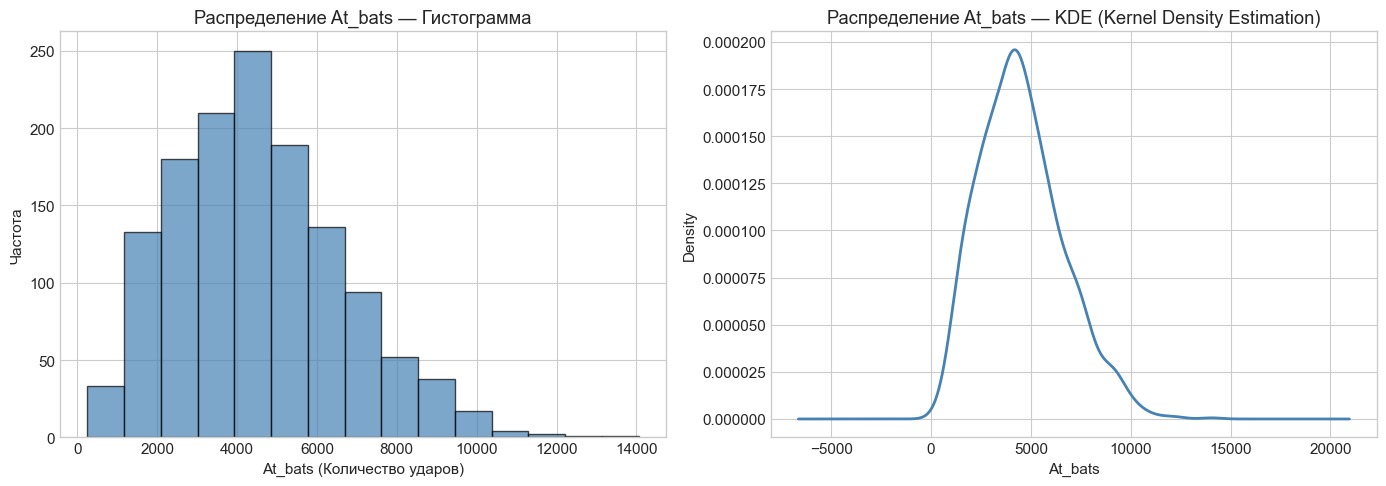

In [5]:
# Визуализация распределения численного признака (At_bats)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(df['At_bats'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('At_bats (Количество ударов)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение At_bats — Гистограмма')

# KDE
df['At_bats'].plot(kind='kde', ax=axes[1], color='steelblue', linewidth=2)
axes[1].set_xlabel('At_bats')
axes[1].set_title('Распределение At_bats — KDE (Kernel Density Estimation)')

plt.tight_layout()
plt.show()

### 2.1 Реализация наивного метода

In [6]:
def generate_naive_synthetic(df, cat_features, num_features, n_samples=None):
    """
    Наивная генерация синтетических данных.
    Каждый столбец генерируется независимо от других.
    
    Параметры:
    ----------
    df : pd.DataFrame - исходные данные
    cat_features : list - список категориальных признаков
    num_features : list - список численных признаков
    n_samples : int - количество генерируемых строк (по умолчанию = len(df))
    
    Возвращает:
    ----------
    pd.DataFrame - синтетические данные
    """
    if n_samples is None:
        n_samples = len(df)
    
    synth_data = {}
    
    # === Генерация численных признаков ===
    for num_feat in num_features:
        # Создаём гистограмму для моделирования распределения
        hist_counts, bin_edges = np.histogram(df[num_feat], bins=10, density=True)
        
        # Центры бинов
        bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
        
        # Вероятности для каждого бина
        probabilities = hist_counts / hist_counts.sum()
        
        # Выбираем бины пропорционально вероятностям
        selected_centers = np.random.choice(bin_centers, p=probabilities, size=n_samples)
        
        # Добавляем случайный джиттер для разнообразия
        # Джиттер пропорционален стандартному отклонению признака
        jitter = (np.random.random(n_samples) - 0.5) * df[num_feat].std() * 0.5
        vals = selected_centers + jitter
        
        synth_data[num_feat] = vals
    
    # === Генерация категориальных признаков ===
    for cat_feat in cat_features:
        # Подсчёт частот каждого уникального значения
        value_counts = df[cat_feat].value_counts(normalize=True)
        
        # Выбираем значения пропорционально частотам
        vals = np.random.choice(
            list(value_counts.index), 
            p=list(value_counts.values), 
            size=n_samples
        )
        synth_data[cat_feat] = vals
    
    # Собираем DataFrame в правильном порядке столбцов
    synth_df = pd.DataFrame(synth_data)
    synth_df = synth_df[df.columns]  # Сохраняем исходный порядок столбцов
    
    return synth_df

In [7]:
# Генерация синтетических данных наивным методом
synth_naive = generate_naive_synthetic(df, cat_features, num_features)

print(f"Размер синтетических данных: {synth_naive.shape}")
synth_naive.head(10)

Размер синтетических данных: (1340, 16)


,Number_seasons,Games_played,At_bats,Runs,Hits,Doubles,Triples,Home_runs,RBIs,Walks,Strikeouts,Batting_average,On_base_pct,Slugging_pct,Fielding_ave,Position
0,12.020013,972.476058,5156.916730,1597.633991,1667.269822,539.693569,55.006606,57.618639,331.779487,358.445825,572.188894,0.249521,0.328615,0.428116,0.949939,Third_base
1,18.741388,1612.546524,2579.104884,316.383311,774.080824,207.960135,8.857043,15.884940,63.822316,479.275896,638.132163,0.255427,0.355330,0.370737,0.951983,Catcher
2,16.177503,355.847840,4955.605270,145.993756,1125.485816,141.730636,11.254905,28.367774,548.006911,515.211383,1676.215226,0.269643,0.327415,0.421781,0.955404,First_base
3,14.356233,1080.140706,4875.828837,775.751552,1989.140423,198.270100,179.712807,27.376527,524.108394,515.348528,338.761343,0.275865,0.323584,0.329157,0.986146,Shortstop
4,11.180598,1040.431699,3659.681388,583.063067,1660.229915,101.365752,74.606986,194.937470,553.342914,157.322546,954.822906,0.232652,0.388719,0.381610,0.960481,Catcher
5,10.683163,395.295720,10935.688164,202.175917,1076.795078,120.037081,67.453357,95.192922,319.865659,576.591116,1108.772209,0.231266,0.322526,0.425879,0.977462,Outfield
6,10.558405,626.560961,5532.519170,876.729853,1045.399967,200.011090,39.119934,56.471659,1069.792758,263.035968,196.929325,0.291635,0.324287,0.435510,0.924941,Outfield
7,16.997771,906.285879,3749.456642,87.256225,1254.546260,362.669437,98.430859,53.837527,215.964734,128.244700,403.694701,0.300109,0.356241,0.430735,0.967237,Third_base
8,14.764702,1399.467917,6631.520547,1014.574822,796.894646,100.910195,56.402821,120.695906,1078.370456,361.485913,53.553677,0.273856,0.324396,0.331643,0.923426,First_base
9,14.878827,959.281614,2744.416020,363.148923,1463.495787,309.742845,134.512611,186.713732,438.591833,1588.493737,464.326320,0.254052,0.347715,0.431500,0.958826,Catcher


### 2.2 Проблема наивного метода: потеря корреляций

**Ключевая проблема:** при независимой генерации столбцов теряются **взаимосвязи между признаками**.

Например:
- Игроки с большим количеством `At_bats` обычно имеют больше `RBIs`
- Больше сезонов → больше ударов, хоум-ранов и т.д.

При наивной генерации эти корреляции **полностью игнорируются**.

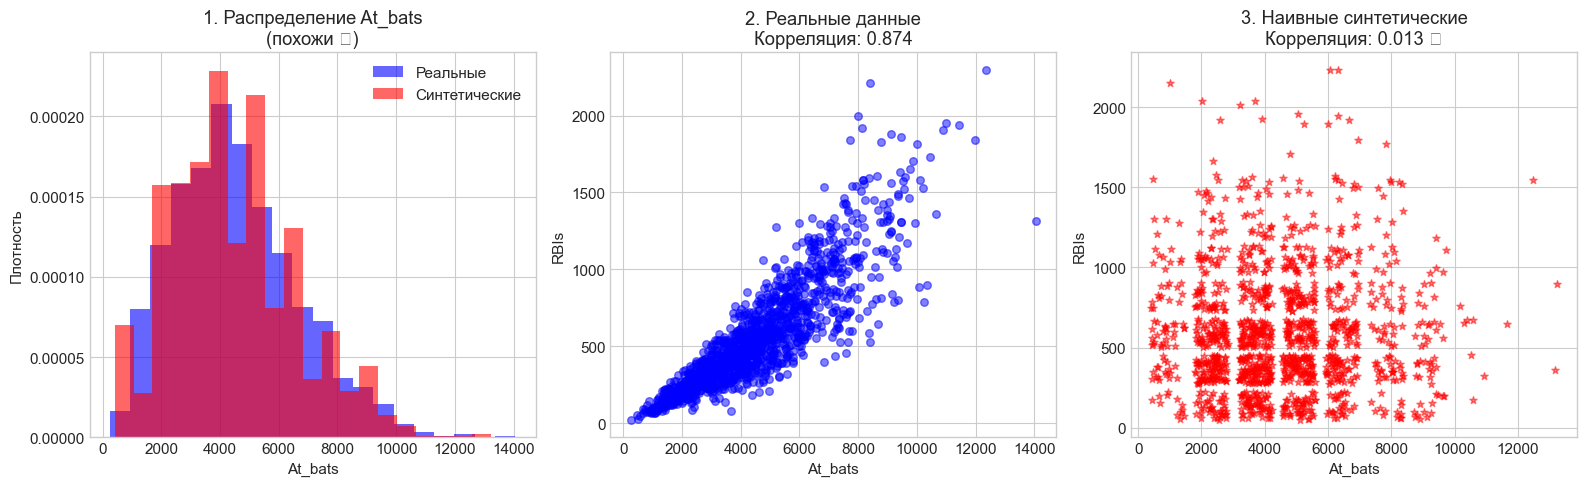


⚠️  Корреляция между At_bats и RBIs:
   Реальные данные:      0.874
   Синтетические данные: 0.013

   Корреляция потеряна! Это делает синтетические данные нереалистичными.


In [8]:
# Сравнение распределений и корреляций
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Распределение At_bats
axes[0].hist(df['At_bats'], bins=20, alpha=0.6, label='Реальные', color='blue', density=True)
axes[0].hist(synth_naive['At_bats'], bins=20, alpha=0.6, label='Синтетические', color='red', density=True)
axes[0].set_xlabel('At_bats')
axes[0].set_ylabel('Плотность')
axes[0].set_title('1. Распределение At_bats\n(похожи ✓)')
axes[0].legend()

# 2. Корреляция в реальных данных
axes[1].scatter(df['At_bats'], df['RBIs'], alpha=0.5, color='blue', s=30)
axes[1].set_xlabel('At_bats')
axes[1].set_ylabel('RBIs')
corr_real = df['At_bats'].corr(df['RBIs'])
axes[1].set_title(f'2. Реальные данные\nКорреляция: {corr_real:.3f}')

# 3. Корреляция в синтетических данных
axes[2].scatter(synth_naive['At_bats'], synth_naive['RBIs'], alpha=0.5, color='red', s=30, marker='*')
axes[2].set_xlabel('At_bats')
axes[2].set_ylabel('RBIs')
corr_synth = synth_naive['At_bats'].astype(float).corr(synth_naive['RBIs'].astype(float))
axes[2].set_title(f'3. Наивные синтетические\nКорреляция: {corr_synth:.3f} ✗')

plt.tight_layout()
plt.show()

print(f"\n⚠️  Корреляция между At_bats и RBIs:")
print(f"   Реальные данные:      {corr_real:.3f}")
print(f"   Синтетические данные: {corr_synth:.3f}")
print(f"\n   Корреляция потеряна! Это делает синтетические данные нереалистичными.")

---
## 3. Метод предиктивной модели (Left-to-Right)

### Идея

Чтобы сохранить взаимосвязи между признаками, будем генерировать значения **последовательно**, учитывая уже сгенерированные столбцы:

1. Генерируем первый столбец по его распределению (как в наивном методе)
2. Для каждого следующего столбца:
   - Обучаем **предиктивную модель** (Random Forest) на реальных данных
   - Предсказываем значения на основе уже сгенерированных столбцов
   - Добавляем случайный джиттер для разнообразия

### Почему Random Forest?

- Хорошо улавливает нелинейные зависимости
- Работает с разными типами данных
- Устойчив к выбросам
- Не требует масштабирования признаков

In [9]:
def generate_left_to_right(df, cat_features, num_features, n_samples=None, verbose=True):
    """
    Генерация синтетических данных методом Left-to-Right.
    Каждый столбец генерируется на основе предыдущих с помощью Random Forest.
    
    Параметры:
    ----------
    df : pd.DataFrame - исходные данные
    cat_features : list - список категориальных признаков
    num_features : list - список численных признаков
    n_samples : int - количество генерируемых строк
    verbose : bool - выводить прогресс
    
    Возвращает:
    ----------
    pd.DataFrame - синтетические данные
    """
    if n_samples is None:
        n_samples = len(df)
    
    synth_data = []
    synth_cols = []
    
    # === ШАГ 1: Генерация первого столбца ===
    feature_0 = df.columns[0]
    
    if feature_0 in num_features:
        # Численный признак — используем гистограмму
        hist_counts, bin_edges = np.histogram(df[feature_0], bins=10, density=True)
        bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
        probabilities = hist_counts / hist_counts.sum()
        
        vals = np.random.choice(bin_centers, p=probabilities, size=n_samples)
        vals = vals + (np.random.random(n_samples) - 0.5) * df[feature_0].std() * 0.3
    else:
        # Категориальный признак — используем частоты
        vc = df[feature_0].value_counts(normalize=True)
        vals = np.random.choice(list(vc.index), p=list(vc.values), size=n_samples)
    
    synth_data.append(vals)
    synth_cols.append(feature_0)
    
    if verbose:
        print(f"[1/{len(df.columns)}] {feature_0}: сгенерировано по распределению")
    
    # === ШАГ 2: Последовательная генерация остальных столбцов ===
    for i, col_name in enumerate(df.columns[1:], 2):
        # Собираем уже сгенерированные данные в DataFrame
        synth_df_temp = pd.DataFrame(np.array(synth_data).T, columns=synth_cols)
        
        # Преобразуем типы для совместимости с моделью
        for col in synth_df_temp.columns:
            if col in num_features:
                synth_df_temp[col] = synth_df_temp[col].astype(float)
        
        if col_name in num_features:
            # === Численный признак ===
            # Обучаем Random Forest Regressor на реальных данных
            regr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            
            # X = уже существующие столбцы, y = текущий столбец
            X_train = df[synth_cols].copy()
            for col in X_train.columns:
                if col in cat_features:
                    X_train[col] = pd.factorize(X_train[col])[0]
            
            regr.fit(X_train, df[col_name])
            
            # Предсказываем на синтетических данных
            X_synth = synth_df_temp.copy()
            for col in X_synth.columns:
                if col in cat_features:
                    # Факторизация с учётом возможных новых категорий
                    mapping = {v: k for k, v in enumerate(df[col].unique())}
                    X_synth[col] = X_synth[col].map(mapping).fillna(-1)
            
            pred = regr.predict(X_synth)
            
            # Добавляем джиттер для разнообразия
            jitter = (np.random.random(n_samples) - 0.5) * np.std(pred) * 0.3
            vals = pred + jitter
            
            if verbose:
                print(f"[{i}/{len(df.columns)}] {col_name}: предсказано RF Regressor")
        
        else:
            # === Категориальный признак ===
            clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            
            X_train = df[synth_cols].copy()
            for col in X_train.columns:
                if col in cat_features:
                    X_train[col] = pd.factorize(X_train[col])[0]
            
            clf.fit(X_train, df[col_name])
            
            X_synth = synth_df_temp.copy()
            for col in X_synth.columns:
                if col in cat_features:
                    mapping = {v: k for k, v in enumerate(df[col].unique())}
                    X_synth[col] = X_synth[col].map(mapping).fillna(-1)
            
            vals = clf.predict(X_synth)
            
            if verbose:
                print(f"[{i}/{len(df.columns)}] {col_name}: предсказано RF Classifier")
        
        synth_data.append(vals)
        synth_cols.append(col_name)
    
    # Собираем итоговый DataFrame
    synth_df = pd.DataFrame(np.array(synth_data).T, columns=synth_cols)
    
    return synth_df

In [10]:
# Генерация синтетических данных методом Left-to-Right
print("Генерация синтетических данных методом Left-to-Right...\n")
synth_l2r = generate_left_to_right(df, cat_features, num_features)

print(f"\nРазмер синтетических данных: {synth_l2r.shape}")

Генерация синтетических данных методом Left-to-Right...

[1/16] Number_seasons: сгенерировано по распределению
[2/16] Games_played: предсказано RF Regressor
[3/16] At_bats: предсказано RF Regressor
[4/16] Runs: предсказано RF Regressor
[5/16] Hits: предсказано RF Regressor
[6/16] Doubles: предсказано RF Regressor
[7/16] Triples: предсказано RF Regressor
[8/16] Home_runs: предсказано RF Regressor
[9/16] RBIs: предсказано RF Regressor
[10/16] Walks: предсказано RF Regressor
[11/16] Strikeouts: предсказано RF Regressor
[12/16] Batting_average: предсказано RF Regressor
[13/16] On_base_pct: предсказано RF Regressor
[14/16] Slugging_pct: предсказано RF Regressor
[15/16] Fielding_ave: предсказано RF Regressor
[16/16] Position: предсказано RF Classifier

Размер синтетических данных: (1340, 16)


In [11]:
synth_l2r.head(10)

,Number_seasons,Games_played,At_bats,Runs,Hits,Doubles,Triples,Home_runs,RBIs,Walks,Strikeouts,Batting_average,On_base_pct,Slugging_pct,Fielding_ave,Position
0,11.166776,1009.961705,3291.210227,394.797032,908.598621,140.803265,32.809256,44.002725,361.220671,279.255745,336.136247,0.266066,0.327431,0.372444,0.973266,Outfield
1,15.725311,1685.440305,5949.505991,841.155432,1636.949006,246.753025,58.44047,101.005355,615.849253,545.116373,604.452057,0.273041,0.336786,0.396432,0.978775,Outfield
2,15.544399,1728.145963,6013.128994,789.677646,1580.343224,249.560692,52.837222,123.98883,600.705841,508.034342,654.574272,0.271681,0.337077,0.399908,0.979773,Outfield
3,10.64133,940.621618,2526.976717,281.539939,626.987433,104.012766,18.762015,31.784611,248.191363,243.111446,270.719487,0.248664,0.322171,0.341949,0.97604,Second_base
4,10.448367,822.641525,2543.365083,343.39793,633.369455,95.869818,22.651236,46.448152,274.412663,277.530832,320.020271,0.253261,0.333381,0.373745,0.977141,Outfield
5,17.596641,1999.757431,7155.944226,983.638679,2024.819696,354.777568,50.265396,213.767534,955.380443,659.763154,930.488437,0.279807,0.346679,0.43391,0.978889,Outfield
6,12.599771,1291.087592,4310.663024,551.617014,1141.038405,176.512949,41.362877,79.438388,492.125984,424.54743,557.570662,0.267733,0.34636,0.385524,0.976563,Outfield
7,10.646065,1042.431202,3372.538168,421.592166,848.94885,125.777837,30.966088,60.517834,375.242975,265.345618,412.180869,0.25925,0.318385,0.380073,0.973433,Outfield
8,18.396301,1966.119678,7388.152949,1084.980914,2217.848141,362.30542,92.328544,101.849855,868.107793,698.061685,651.939023,0.288569,0.352629,0.412971,0.974023,Outfield
9,12.235988,1205.505544,3697.134644,368.61969,900.712643,154.590615,19.787977,56.420126,347.50085,272.895509,480.830943,0.251197,0.308554,0.345699,0.977641,Second_base


### 3.1 Сравнение результатов: наивный метод vs Left-to-Right

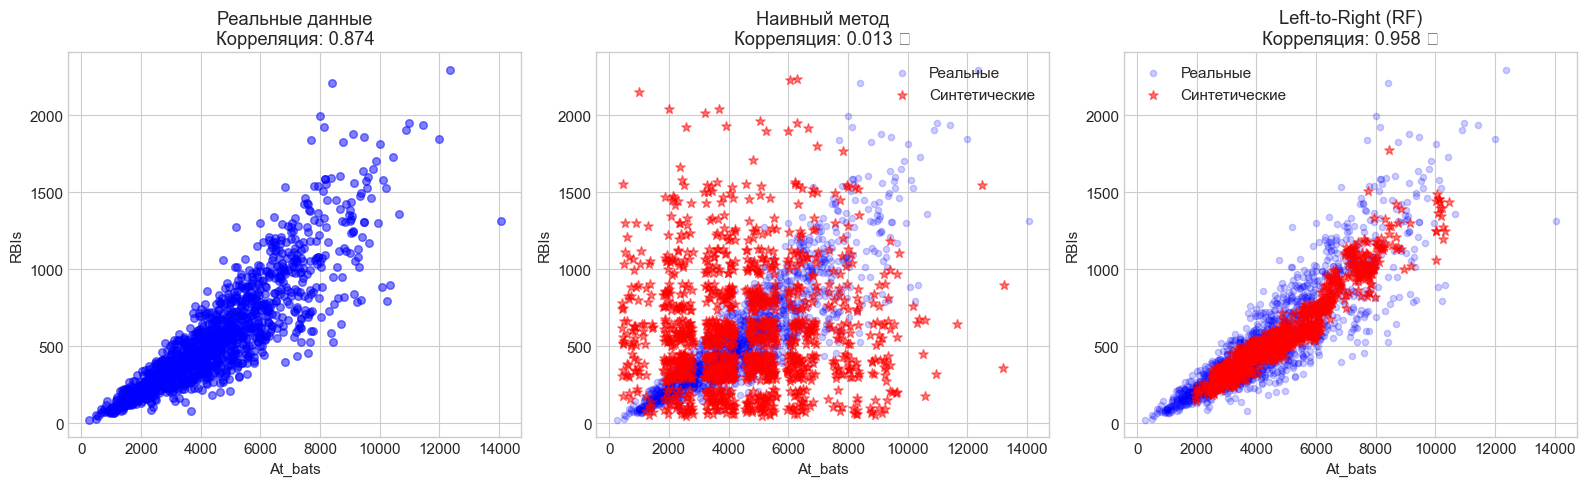


📊 Сравнение корреляций At_bats ↔ RBIs:
   Реальные данные:           0.874
   Наивный метод:             0.013  (потеря корреляции)
   Left-to-Right:             0.958  (корреляция сохранена!)


In [12]:
# Сравнение трёх подходов
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Реальные данные
axes[0].scatter(df['At_bats'], df['RBIs'], alpha=0.5, color='blue', s=30)
axes[0].set_xlabel('At_bats')
axes[0].set_ylabel('RBIs')
corr_real = df['At_bats'].corr(df['RBIs'])
axes[0].set_title(f'Реальные данные\nКорреляция: {corr_real:.3f}')

# 2. Наивный метод
axes[1].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20, label='Реальные')
axes[1].scatter(synth_naive['At_bats'], synth_naive['RBIs'], alpha=0.5, color='red', s=50, marker='*', label='Синтетические')
axes[1].set_xlabel('At_bats')
axes[1].set_ylabel('RBIs')
corr_naive = synth_naive['At_bats'].astype(float).corr(synth_naive['RBIs'].astype(float))
axes[1].set_title(f'Наивный метод\nКорреляция: {corr_naive:.3f} ✗')
axes[1].legend()

# 3. Left-to-Right
axes[2].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20, label='Реальные')
axes[2].scatter(synth_l2r['At_bats'].astype(float), synth_l2r['RBIs'].astype(float), 
                alpha=0.5, color='red', s=50, marker='*', label='Синтетические')
axes[2].set_xlabel('At_bats')
axes[2].set_ylabel('RBIs')
corr_l2r = synth_l2r['At_bats'].astype(float).corr(synth_l2r['RBIs'].astype(float))
axes[2].set_title(f'Left-to-Right (RF)\nКорреляция: {corr_l2r:.3f} ✓')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Сравнение корреляций At_bats ↔ RBIs:")
print(f"   Реальные данные:           {corr_real:.3f}")
print(f"   Наивный метод:             {corr_naive:.3f}  (потеря корреляции)")
print(f"   Left-to-Right:             {corr_l2r:.3f}  (корреляция сохранена!)")

### 3.2 Управление реалистичностью данных

Метод Left-to-Right позволяет **регулировать**, насколько реалистичными будут данные:

1. **Количество используемых признаков:** использовать все предыдущие или только часть
2. **Гиперпараметры Random Forest:** глубина деревьев, количество деревьев
3. **Джиттер:** величина случайного шума

Меньше признаков → больше разнообразия, но менее реалистичные данные.

In [13]:
def generate_left_to_right_controlled(df, cat_features, num_features, 
                                       max_cols_used=None, use_left=True, n_samples=None):
    """
    Генерация с контролем количества используемых признаков.
    
    Параметры:
    ----------
    max_cols_used : int - максимальное количество предыдущих столбцов для предсказания
    use_left : bool - использовать левые (True) или правые (False) столбцы
    """
    if n_samples is None:
        n_samples = len(df)
    
    synth_data = []
    synth_cols = []
    
    # Первый столбец
    feature_0 = df.columns[0]
    if feature_0 in num_features:
        hist_counts, bin_edges = np.histogram(df[feature_0], bins=10, density=True)
        bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
        probabilities = hist_counts / hist_counts.sum()
        vals = np.random.choice(bin_centers, p=probabilities, size=n_samples)
        vals = vals + (np.random.random(n_samples) - 0.5) * df[feature_0].std() * 0.3
    else:
        vc = df[feature_0].value_counts(normalize=True)
        vals = np.random.choice(list(vc.index), p=list(vc.values), size=n_samples)
    
    synth_data.append(vals)
    synth_cols.append(feature_0)
    
    for col_name in df.columns[1:]:
        synth_df_temp = pd.DataFrame(np.array(synth_data).T, columns=synth_cols)
        
        for col in synth_df_temp.columns:
            if col in num_features:
                synth_df_temp[col] = synth_df_temp[col].astype(float)
        
        # Выбираем подмножество столбцов
        if max_cols_used is not None and len(synth_cols) > max_cols_used:
            if use_left:
                use_cols = synth_cols[:max_cols_used]
            else:
                use_cols = synth_cols[-max_cols_used:]
        else:
            use_cols = synth_cols
        
        if col_name in num_features:
            regr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            X_train = df[use_cols].copy()
            for col in X_train.columns:
                if col in cat_features:
                    X_train[col] = pd.factorize(X_train[col])[0]
            regr.fit(X_train, df[col_name])
            
            X_synth = synth_df_temp[use_cols].copy()
            for col in X_synth.columns:
                if col in cat_features:
                    mapping = {v: k for k, v in enumerate(df[col].unique())}
                    X_synth[col] = X_synth[col].map(mapping).fillna(-1)
            
            pred = regr.predict(X_synth)
            vals = pred + (np.random.random(n_samples) - 0.5) * np.std(pred) * 0.3
        else:
            clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            X_train = df[use_cols].copy()
            for col in X_train.columns:
                if col in cat_features:
                    X_train[col] = pd.factorize(X_train[col])[0]
            clf.fit(X_train, df[col_name])
            
            X_synth = synth_df_temp[use_cols].copy()
            for col in X_synth.columns:
                if col in cat_features:
                    mapping = {v: k for k, v in enumerate(df[col].unique())}
                    X_synth[col] = X_synth[col].map(mapping).fillna(-1)
            
            vals = clf.predict(X_synth)
        
        synth_data.append(vals)
        synth_cols.append(col_name)
    
    return pd.DataFrame(np.array(synth_data).T, columns=synth_cols)

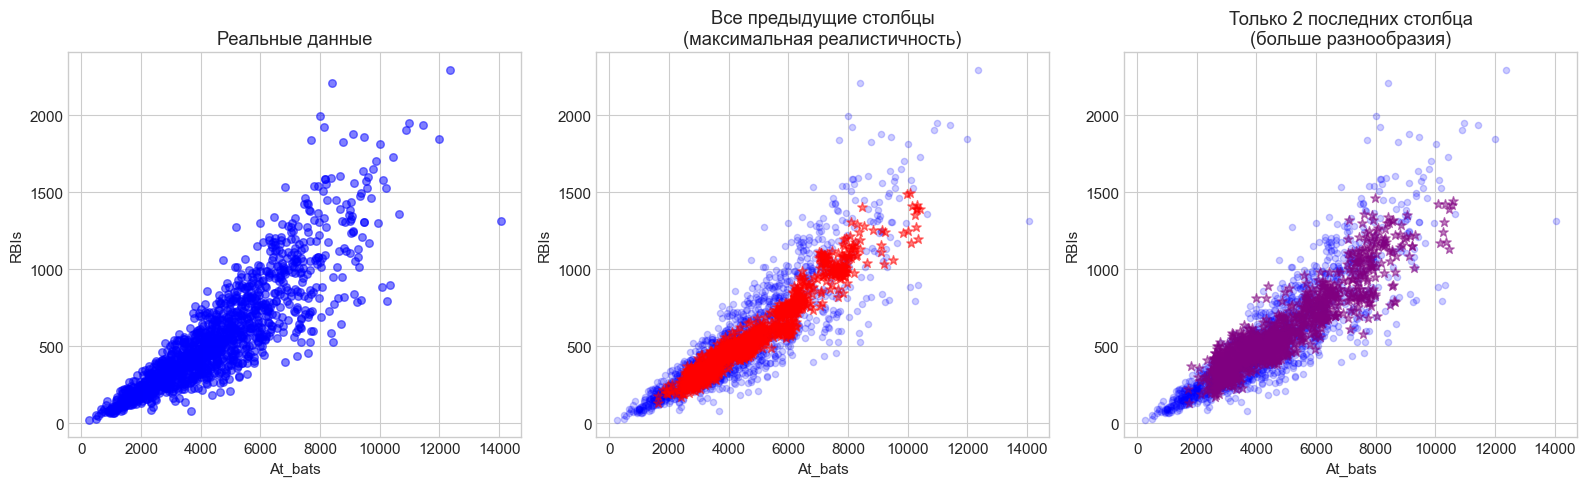

In [14]:
# Сравнение: использование всех vs. 2 последних столбцов
synth_all_cols = generate_left_to_right_controlled(df, cat_features, num_features, max_cols_used=None)
synth_2_cols = generate_left_to_right_controlled(df, cat_features, num_features, max_cols_used=2, use_left=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Реальные
axes[0].scatter(df['At_bats'], df['RBIs'], alpha=0.5, color='blue', s=30)
axes[0].set_xlabel('At_bats')
axes[0].set_ylabel('RBIs')
axes[0].set_title('Реальные данные')

# Все столбцы
axes[1].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20)
axes[1].scatter(synth_all_cols['At_bats'].astype(float), synth_all_cols['RBIs'].astype(float), 
                alpha=0.5, color='red', s=50, marker='*')
axes[1].set_xlabel('At_bats')
axes[1].set_ylabel('RBIs')
axes[1].set_title('Все предыдущие столбцы\n(максимальная реалистичность)')

# Только 2 последних столбца
axes[2].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20)
axes[2].scatter(synth_2_cols['At_bats'].astype(float), synth_2_cols['RBIs'].astype(float), 
                alpha=0.5, color='purple', s=50, marker='*')
axes[2].set_xlabel('At_bats')
axes[2].set_ylabel('RBIs')
axes[2].set_title('Только 2 последних столбца\n(больше разнообразия)')

plt.tight_layout()
plt.show()

---
## 4. Gaussian Mixture Model (GMM)

### Идея

**Gaussian Mixture Model** — это генеративная модель, которая описывает распределение данных как смесь нескольких гауссовых распределений (кластеров).

Каждый кластер характеризуется:
- **Центром** (mean) — среднее положение в пространстве признаков
- **Весом** — вероятность принадлежности точки к этому кластеру
- **Ковариационной матрицей** — форма и ориентация кластера

### Преимущества GMM для генерации данных

1. **Сохранение корреляций:** ковариационные матрицы учитывают зависимости между признаками
2. **Гибкость:** может моделировать сложные мультимодальные распределения
3. **Простота генерации:** встроенный метод `sample()`

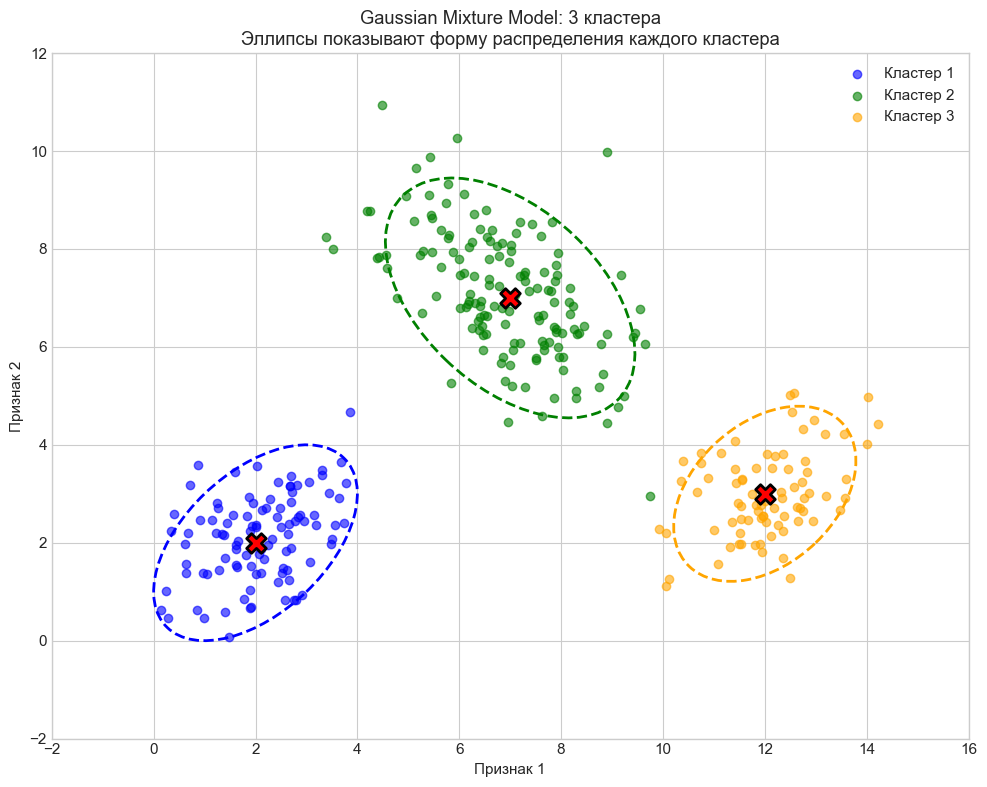

In [15]:
# Визуализация идеи GMM на 2D данных
from scipy.stats import multivariate_normal

# Создаём синтетический пример для иллюстрации
np.random.seed(42)

# 3 кластера
cluster1 = np.random.multivariate_normal([2, 2], [[1, 0.5], [0.5, 1]], 100)
cluster2 = np.random.multivariate_normal([7, 7], [[1.5, -0.7], [-0.7, 1.5]], 150)
cluster3 = np.random.multivariate_normal([12, 3], [[0.8, 0.3], [0.3, 0.8]], 80)

demo_data = np.vstack([cluster1, cluster2, cluster3])

fig, ax = plt.subplots(figsize=(10, 8))

# Точки данных
ax.scatter(cluster1[:, 0], cluster1[:, 1], alpha=0.6, color='blue', label='Кластер 1')
ax.scatter(cluster2[:, 0], cluster2[:, 1], alpha=0.6, color='green', label='Кластер 2')
ax.scatter(cluster3[:, 0], cluster3[:, 1], alpha=0.6, color='orange', label='Кластер 3')

# Центры кластеров
centers = [[2, 2], [7, 7], [12, 3]]
for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], s=200, marker='X', color='red', edgecolor='black', linewidth=2)

# Эллипсы (контуры плотности)
from matplotlib.patches import Ellipse

def draw_ellipse(mean, cov, ax, color, n_std=2):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    ellipse = Ellipse(mean, width, height, angle=angle, fill=False, 
                      color=color, linewidth=2, linestyle='--')
    ax.add_patch(ellipse)

covs = [[[1, 0.5], [0.5, 1]], [[1.5, -0.7], [-0.7, 1.5]], [[0.8, 0.3], [0.3, 0.8]]]
colors = ['blue', 'green', 'orange']

for mean, cov, color in zip(centers, covs, colors):
    draw_ellipse(mean, cov, ax, color)

ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_title('Gaussian Mixture Model: 3 кластера\nЭллипсы показывают форму распределения каждого кластера')
ax.legend()
ax.set_xlim(-2, 16)
ax.set_ylim(-2, 12)

plt.tight_layout()
plt.show()

### 4.1 Подготовка данных для GMM

GMM работает только с **численными данными**, поэтому:
1. Кодируем категориальные признаки (one-hot encoding)
2. Удаляем сильные выбросы (они могут исказить модель)

In [16]:
# Подготовка данных для GMM

# One-hot кодирование категориальных признаков
df_encoded = pd.get_dummies(df)

print(f"Размер до кодирования: {df.shape}")
print(f"Размер после кодирования: {df_encoded.shape}")
print(f"\nНовые столбцы (первые 10): {list(df_encoded.columns[:10])}")

Размер до кодирования: (1340, 16)
Размер после кодирования: (1340, 22)

Новые столбцы (первые 10): ['Number_seasons', 'Games_played', 'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_runs', 'RBIs', 'Walks']


In [17]:
# Удаление сильных выбросов с помощью Isolation Forest
np.random.seed(0)

clf_if = IsolationForest(contamination=0.05, random_state=42)  # 5% выбросов
clf_if.fit(df_encoded)

# Получаем скоры аномальности
anomaly_scores = clf_if.decision_function(df_encoded)

# Оставляем только "чистые" данные (убираем 50 самых аномальных)
n_outliers_to_remove = 50
clean_indices = np.argsort(anomaly_scores)[n_outliers_to_remove:]
df_clean = df_encoded.iloc[clean_indices]

print(f"Удалено выбросов: {n_outliers_to_remove}")
print(f"Размер очищенных данных: {df_clean.shape}")

Удалено выбросов: 50
Размер очищенных данных: (1290, 22)


### 4.2 Выбор оптимального количества кластеров

Используем **BIC (Bayesian Information Criterion)** — чем меньше, тем лучше.

In [18]:
# Поиск оптимального количества кластеров
bic_scores = []
n_clusters_range = range(2, 12)

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(df_clean)
    bic = gmm.bic(df_clean)
    bic_scores.append(bic)
    print(f"n_clusters={n_clusters}: BIC={bic:.2f}")

best_n_clusters = n_clusters_range[np.argmin(bic_scores)]
print(f"\n✓ Оптимальное количество кластеров: {best_n_clusters}")

n_clusters=2: BIC=104909.14
n_clusters=3: BIC=60590.85
n_clusters=4: BIC=72501.48
n_clusters=5: BIC=63309.35
n_clusters=6: BIC=62374.17
n_clusters=7: BIC=63441.34
n_clusters=8: BIC=49866.33
n_clusters=9: BIC=64733.05
n_clusters=10: BIC=57203.84
n_clusters=11: BIC=69833.59

✓ Оптимальное количество кластеров: 8


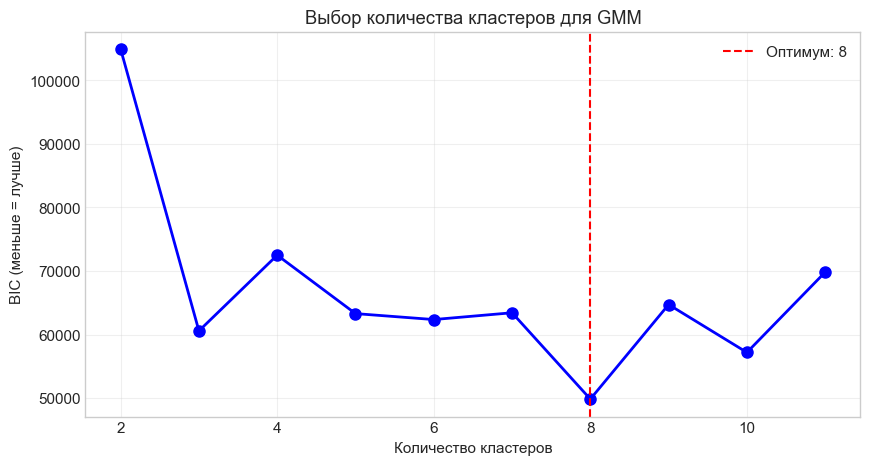

In [19]:
# Визуализация BIC
plt.figure(figsize=(10, 5))
plt.plot(list(n_clusters_range), bic_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(best_n_clusters, color='red', linestyle='--', label=f'Оптимум: {best_n_clusters}')
plt.xlabel('Количество кластеров')
plt.ylabel('BIC (меньше = лучше)')
plt.title('Выбор количества кластеров для GMM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.3 Обучение GMM и генерация данных

In [20]:
# Обучение GMM с оптимальным числом кластеров
gmm = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm.fit(df_clean)

print(f"GMM обучена с {best_n_clusters} кластерами")
print(f"\nВеса кластеров:")
for i, w in enumerate(gmm.weights_):
    print(f"  Кластер {i+1}: {w:.3f} ({w*100:.1f}%)")

GMM обучена с 8 кластерами

Веса кластеров:
  Кластер 1: 0.204 (20.4%)
  Кластер 2: 0.011 (1.1%)
  Кластер 3: 0.013 (1.3%)
  Кластер 4: 0.011 (1.1%)
  Кластер 5: 0.219 (21.9%)
  Кластер 6: 0.317 (31.7%)
  Кластер 7: 0.014 (1.4%)
  Кластер 8: 0.211 (21.1%)


In [21]:
# Генерация синтетических данных
n_synth_samples = 500

synth_samples, cluster_labels = gmm.sample(n_samples=n_synth_samples)
synth_gmm = pd.DataFrame(synth_samples, columns=df_encoded.columns)

print(f"Сгенерировано {n_synth_samples} синтетических записей")
print(f"\nРаспределение по кластерам:")
for i in range(best_n_clusters):
    count = (cluster_labels == i).sum()
    print(f"  Кластер {i+1}: {count} ({count/n_synth_samples*100:.1f}%)")

Сгенерировано 500 синтетических записей

Распределение по кластерам:
  Кластер 1: 97 (19.4%)
  Кластер 2: 7 (1.4%)
  Кластер 3: 7 (1.4%)
  Кластер 4: 3 (0.6%)
  Кластер 5: 115 (23.0%)
  Кластер 6: 162 (32.4%)
  Кластер 7: 12 (2.4%)
  Кластер 8: 97 (19.4%)


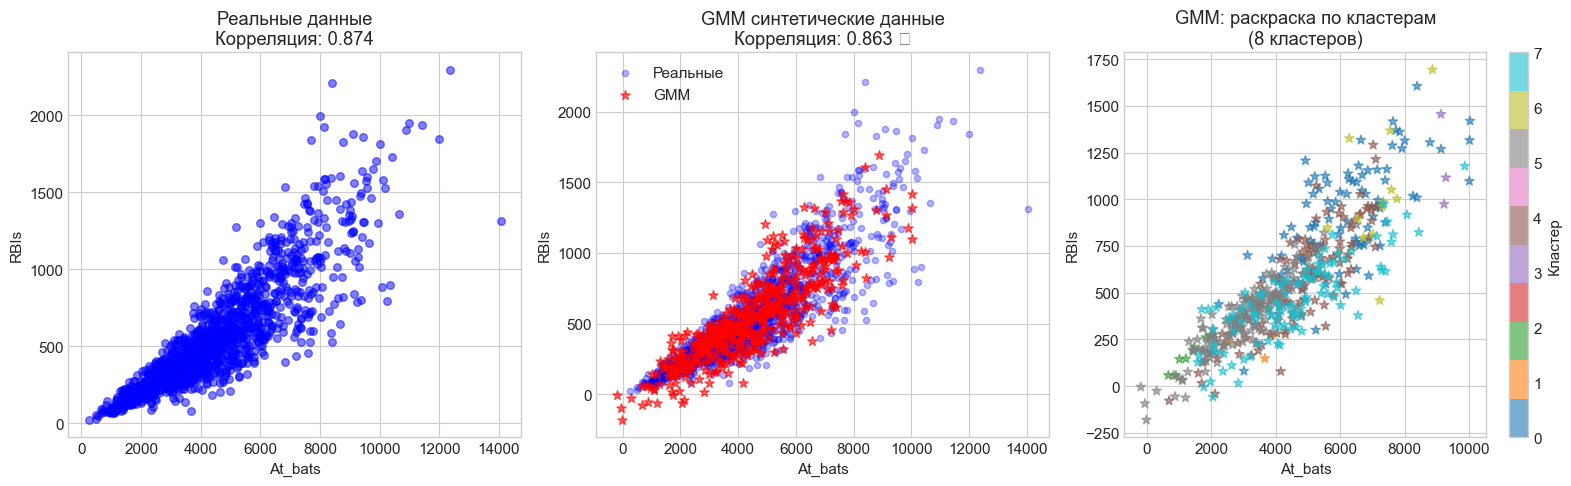

In [22]:
# Сравнение реальных и синтетических данных (GMM)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Реальные данные
axes[0].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.5, color='blue', s=30)
axes[0].set_xlabel('At_bats')
axes[0].set_ylabel('RBIs')
corr_real = df_encoded['At_bats'].corr(df_encoded['RBIs'])
axes[0].set_title(f'Реальные данные\nКорреляция: {corr_real:.3f}')

# 2. Наложение реальных и GMM
axes[1].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.3, color='blue', s=20, label='Реальные')
axes[1].scatter(synth_gmm['At_bats'], synth_gmm['RBIs'], alpha=0.6, color='red', s=50, marker='*', label='GMM')
axes[1].set_xlabel('At_bats')
axes[1].set_ylabel('RBIs')
corr_gmm = synth_gmm['At_bats'].corr(synth_gmm['RBIs'])
axes[1].set_title(f'GMM синтетические данные\nКорреляция: {corr_gmm:.3f} ✓')
axes[1].legend()

# 3. Только GMM с цветом по кластерам
scatter = axes[2].scatter(synth_gmm['At_bats'], synth_gmm['RBIs'], 
                          c=cluster_labels, cmap='tab10', alpha=0.6, s=50, marker='*')
axes[2].set_xlabel('At_bats')
axes[2].set_ylabel('RBIs')
axes[2].set_title(f'GMM: раскраска по кластерам\n({best_n_clusters} кластеров)')
plt.colorbar(scatter, ax=axes[2], label='Кластер')

plt.tight_layout()
plt.show()

### 4.4 Создание более разнообразных данных

Если нужно сгенерировать данные с **большим разбросом** (например, для тестирования детекторов выбросов), можно **модифицировать ковариационные матрицы** GMM.

In [23]:
# Создание копии GMM с увеличенными ковариациями
import copy

gmm_wide = copy.deepcopy(gmm)

# Увеличиваем ковариации в 20 раз
covariance_multiplier = 20.0

for i in range(len(gmm_wide.covariances_)):
    gmm_wide.covariances_[i] = gmm_wide.covariances_[i] * covariance_multiplier

# Генерация данных с расширенными ковариациями
synth_samples_wide, _ = gmm_wide.sample(n_samples=n_synth_samples)
synth_gmm_wide = pd.DataFrame(synth_samples_wide, columns=df_encoded.columns)

print(f"Сгенерировано {n_synth_samples} записей с коэффициентом расширения {covariance_multiplier}x")

Сгенерировано 500 записей с коэффициентом расширения 20.0x


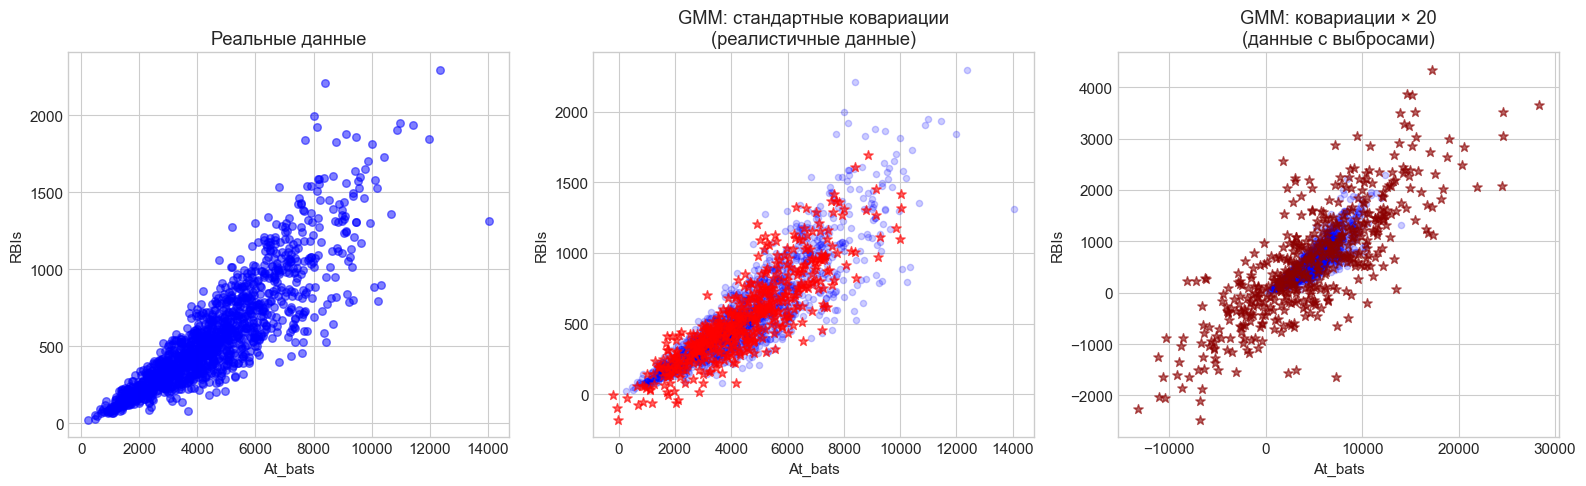

⚠️  Расширенная GMM генерирует данные за пределами типичного распределения —
   это полезно для тестирования детекторов выбросов!


In [24]:
# Сравнение: стандартная GMM vs расширенная
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Реальные
axes[0].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.5, color='blue', s=30)
axes[0].set_xlabel('At_bats')
axes[0].set_ylabel('RBIs')
axes[0].set_title('Реальные данные')

# Стандартная GMM
axes[1].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.2, color='blue', s=20)
axes[1].scatter(synth_gmm['At_bats'], synth_gmm['RBIs'], alpha=0.6, color='red', s=50, marker='*')
axes[1].set_xlabel('At_bats')
axes[1].set_ylabel('RBIs')
axes[1].set_title('GMM: стандартные ковариации\n(реалистичные данные)')

# Расширенная GMM
axes[2].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.2, color='blue', s=20)
axes[2].scatter(synth_gmm_wide['At_bats'], synth_gmm_wide['RBIs'], 
                alpha=0.6, color='darkred', s=50, marker='*')
axes[2].set_xlabel('At_bats')
axes[2].set_ylabel('RBIs')
axes[2].set_title(f'GMM: ковариации × {covariance_multiplier:.0f}\n(данные с выбросами)')

plt.tight_layout()
plt.show()

print("⚠️  Расширенная GMM генерирует данные за пределами типичного распределения —")
print("   это полезно для тестирования детекторов выбросов!")

---
## 5. Оценка качества синтетических данных

### Методы оценки

1. **Визуальное сравнение** — распределения, scatter plots
2. **Статистики** — корреляции, средние, дисперсии
3. **Классификатор real vs synthetic** — если модель легко различает, данные плохие
4. **Детекция выбросов** — синтетические данные не должны быть выбросами

In [25]:
def evaluate_synthetic_data(real_df, synth_df, feature_pairs=None):
    """
    Оценка качества синтетических данных.
    
    Возвращает словарь с метриками.
    """
    results = {}
    
    # Находим общие числовые столбцы
    common_cols = list(set(real_df.columns) & set(synth_df.columns))
    num_cols = [c for c in common_cols if real_df[c].dtype in ['float64', 'int64', 'float32', 'int32']]
    
    # 1. Сравнение средних
    mean_diff = {}
    for col in num_cols[:10]:  # Берём первые 10
        real_mean = real_df[col].mean()
        synth_mean = synth_df[col].astype(float).mean()
        mean_diff[col] = abs(real_mean - synth_mean) / (real_mean + 1e-10)
    results['mean_relative_diff'] = mean_diff
    
    # 2. Сравнение корреляций
    if feature_pairs is None:
        feature_pairs = [('At_bats', 'RBIs'), ('At_bats', 'Hits'), ('Hits', 'RBIs')]
    
    corr_comparison = {}
    for f1, f2 in feature_pairs:
        if f1 in num_cols and f2 in num_cols:
            real_corr = real_df[f1].corr(real_df[f2])
            synth_corr = synth_df[f1].astype(float).corr(synth_df[f2].astype(float))
            corr_comparison[f"{f1}-{f2}"] = {
                'real': real_corr,
                'synthetic': synth_corr,
                'diff': abs(real_corr - synth_corr)
            }
    results['correlations'] = corr_comparison
    
    return results

In [26]:
# Оценка всех методов
print("="*60)
print("СРАВНЕНИЕ МЕТОДОВ ГЕНЕРАЦИИ СИНТЕТИЧЕСКИХ ДАННЫХ")
print("="*60)

# Конвертируем для совместимости
synth_naive_eval = synth_naive.copy()
synth_l2r_eval = synth_l2r.copy()

methods = {
    'Наивный метод': synth_naive_eval,
    'Left-to-Right': synth_l2r_eval,
    'GMM': synth_gmm[df_encoded.columns[:len(df.columns)]]
}

# Сравнение корреляций
print("\n📊 Сравнение корреляций At_bats ↔ RBIs:")
print("-" * 40)

real_corr = df['At_bats'].corr(df['RBIs'])
print(f"  Реальные данные:     {real_corr:.3f}")

for name, synth in methods.items():
    try:
        corr = synth['At_bats'].astype(float).corr(synth['RBIs'].astype(float))
        diff = abs(real_corr - corr)
        quality = "✓" if diff < 0.1 else "✗"
        print(f"  {name:20s} {corr:.3f}  (diff: {diff:.3f}) {quality}")
    except:
        print(f"  {name:20s} — ошибка расчёта")

СРАВНЕНИЕ МЕТОДОВ ГЕНЕРАЦИИ СИНТЕТИЧЕСКИХ ДАННЫХ

📊 Сравнение корреляций At_bats ↔ RBIs:
----------------------------------------
  Реальные данные:     0.874
  Наивный метод        0.013  (diff: 0.861) ✗
  Left-to-Right        0.958  (diff: 0.084) ✓
  GMM                  0.863  (diff: 0.011) ✓


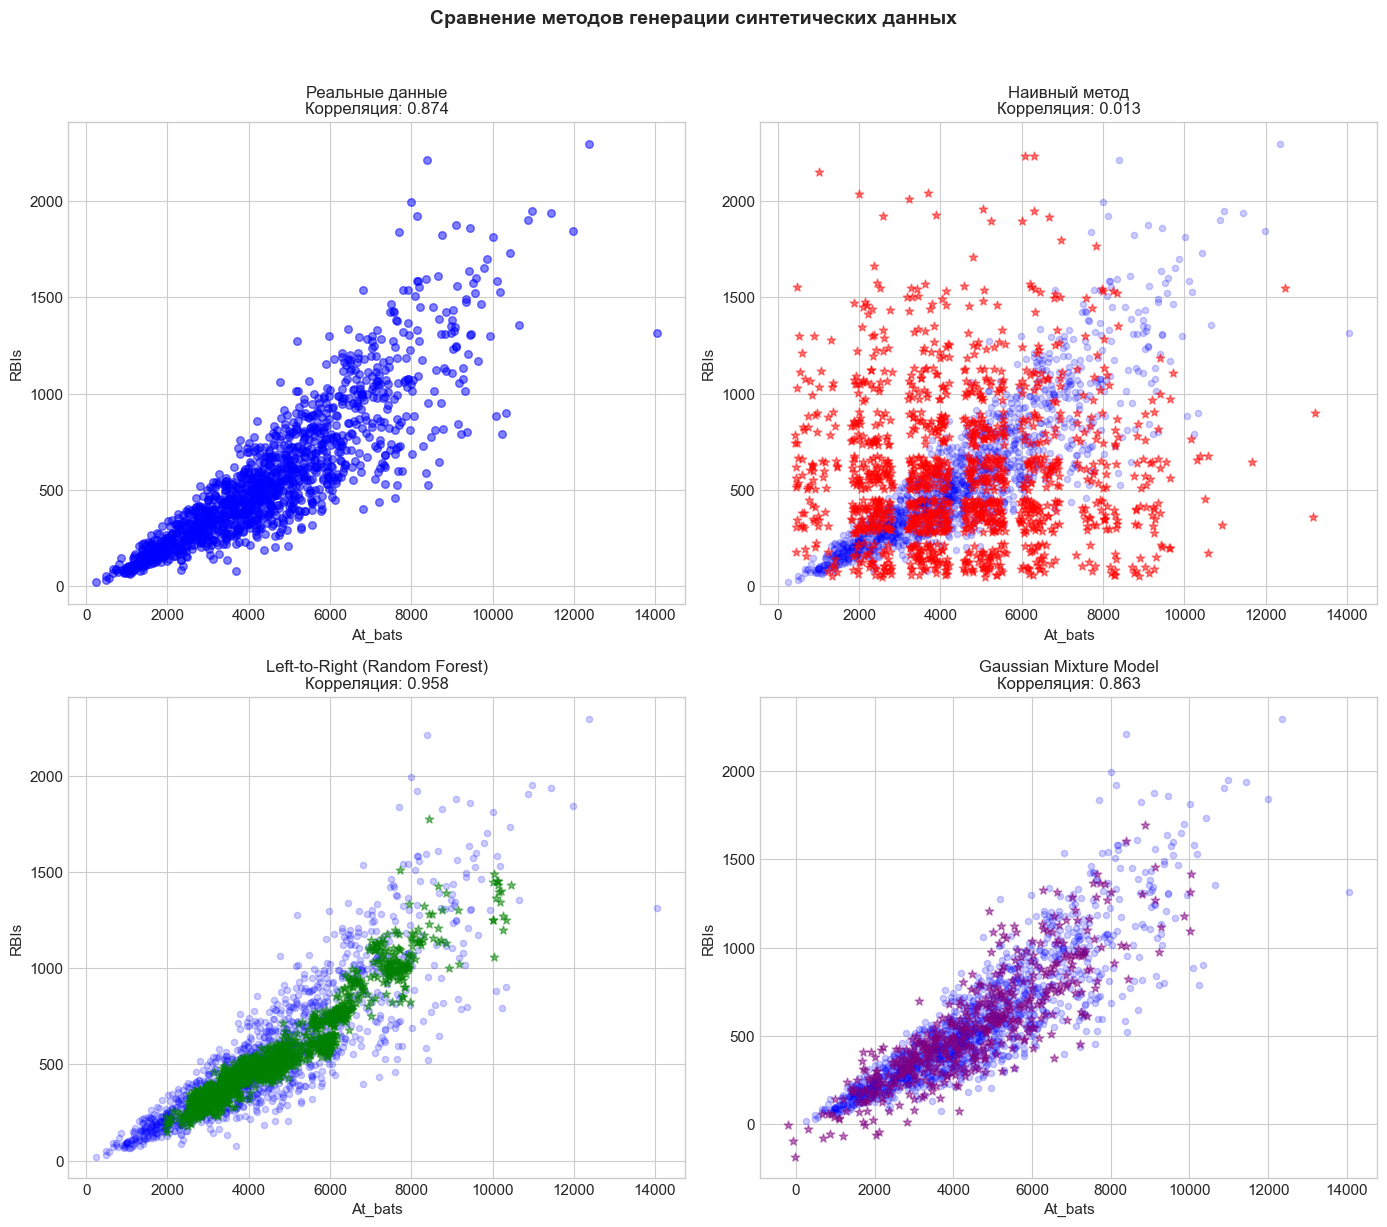

In [27]:
# Визуальное сравнение всех методов
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Реальные
axes[0, 0].scatter(df['At_bats'], df['RBIs'], alpha=0.5, color='blue', s=30)
axes[0, 0].set_xlabel('At_bats')
axes[0, 0].set_ylabel('RBIs')
axes[0, 0].set_title(f'Реальные данные\nКорреляция: {real_corr:.3f}', fontsize=12)

# Наивный
axes[0, 1].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20)
axes[0, 1].scatter(synth_naive['At_bats'], synth_naive['RBIs'], alpha=0.5, color='red', s=40, marker='*')
corr_n = synth_naive['At_bats'].astype(float).corr(synth_naive['RBIs'].astype(float))
axes[0, 1].set_xlabel('At_bats')
axes[0, 1].set_ylabel('RBIs')
axes[0, 1].set_title(f'Наивный метод\nКорреляция: {corr_n:.3f}', fontsize=12)

# Left-to-Right
axes[1, 0].scatter(df['At_bats'], df['RBIs'], alpha=0.2, color='blue', s=20)
axes[1, 0].scatter(synth_l2r['At_bats'].astype(float), synth_l2r['RBIs'].astype(float), 
                   alpha=0.5, color='green', s=40, marker='*')
corr_lr = synth_l2r['At_bats'].astype(float).corr(synth_l2r['RBIs'].astype(float))
axes[1, 0].set_xlabel('At_bats')
axes[1, 0].set_ylabel('RBIs')
axes[1, 0].set_title(f'Left-to-Right (Random Forest)\nКорреляция: {corr_lr:.3f}', fontsize=12)

# GMM
axes[1, 1].scatter(df_encoded['At_bats'], df_encoded['RBIs'], alpha=0.2, color='blue', s=20)
axes[1, 1].scatter(synth_gmm['At_bats'], synth_gmm['RBIs'], alpha=0.5, color='purple', s=40, marker='*')
corr_g = synth_gmm['At_bats'].corr(synth_gmm['RBIs'])
axes[1, 1].set_xlabel('At_bats')
axes[1, 1].set_ylabel('RBIs')
axes[1, 1].set_title(f'Gaussian Mixture Model\nКорреляция: {corr_g:.3f}', fontsize=12)

plt.suptitle('Сравнение методов генерации синтетических данных', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Итоги и рекомендации

### Сравнение методов

| Метод | Плюсы | Минусы | Когда использовать |
|-------|-------|--------|--------------------|
| **Наивный** | Простой, быстрый | Теряет корреляции | Когда связи между признаками не важны |
| **Left-to-Right** | Сохраняет корреляции, гибкий | Порядок столбцов влияет на результат | Когда важны зависимости между признаками |
| **GMM** | Генеративная модель, естественные данные | Требует численных данных, выбор числа кластеров | Когда данные хорошо кластеризуются |

### Советы по выбору метода

1. **Для тестирования систем** — наивный метод может быть достаточным
2. **Для аугментации ML данных** — используйте Left-to-Right или GMM
3. **Для генерации выбросов** — GMM с модифицированными ковариациями
4. **Для анонимизации** — GMM или более сложные методы (VAE, GAN)

### Дополнительные методы (не рассмотренные)

- **CTGAN** — условная GAN для табличных данных
- **Synthetic Data Vault (SDV)** — библиотека Python
- **Bayesian Networks** — для данных с известной структурой зависимостей
- **Variational Autoencoders (VAE)** — для сложных распределений

---
## 7. Ссылки и ресурсы

- **Оригинальная статья:** [W. Brett Kennedy — Robust methods to generate synthetic table data](https://medium.com/ai-advances/robust-methods-to-generate-synthetic-table-data-91962bcf8466)
- **Книга автора:** [Outlier Detection in Python](https://www.manning.com/books/outlier-detection-in-python)
- **Synthetic Data Vault:** https://github.com/sdv-dev/SDV
- **CTGAN:** https://github.com/sdv-dev/CTGAN
- **Faker (генерация фейковых данных):** https://faker.readthedocs.io/

In [28]:
print("\n" + "="*60)
print("🎉 Notebook завершён!")
print("="*60)
print("\nВы изучили три метода генерации синтетических табличных данных:")
print("  1. Наивный метод (независимая генерация столбцов)")
print("  2. Left-to-Right с Random Forest (учёт зависимостей)")
print("  3. Gaussian Mixture Model (генеративная модель)")
print("\nКаждый метод имеет свои применения в зависимости от задачи.")


🎉 Notebook завершён!

Вы изучили три метода генерации синтетических табличных данных:
  1. Наивный метод (независимая генерация столбцов)
  2. Left-to-Right с Random Forest (учёт зависимостей)
  3. Gaussian Mixture Model (генеративная модель)

Каждый метод имеет свои применения в зависимости от задачи.
